In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import networkx as nx
from numba import cuda
import time
import sklearn
import matplotlib.pyplot as plt

import markov_clustering as mc

In [7]:
# Main Functions

import sklearn.preprocessing


def print_matrix(matrix):
    for row in matrix:
        print(" ".join(f"{val:.2f}" for val in row))

def normalize(matrix):
    return sklearn.preprocessing.normalize(matrix, norm="l1", axis=0)

def inflate(matrix, power):
    return normalize(np.power(matrix, power))

def matmulpower(matrix, power):
    if power < 1:
        print("Wrong parameter power.")
        raise ValueError
    
    matrix1 = matrix.copy()
    result = np.zeros(shape=(len(matrix), len(matrix)))
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            for k in range(len(matrix)):
                result[i, j] += matrix[i, k] * matrix1[k, j]

    matrix = result
    power -= 1

    while power > 1:
        result = np.zeros(shape=(len(matrix), len(matrix)))
        for i in range(len(matrix)):
            for j in range(len(matrix)):
                for k in range(len(matrix)):
                    result[i, j] += matrix[i, k] * matrix1[k, j]

        matrix = result
        power -= 1
    return matrix

def expand(matrix, power):
    return np.linalg.matrix_power(matrix, power)

def add_self_loops(matrix):
    for i in range(len(matrix)):
        matrix[i][i] = 1

    return matrix

def run_mcl(matrix, expansion, inflation, iteration):

    matrix = add_self_loops(matrix)

    matrix = normalize(matrix)

    tol = 1e-7
    ptr = 0
    converged = False

    while ptr < iteration and not converged:
        prev_matrix = matrix.copy()

        matrix = expand(matrix, expansion)
        print_matrix(matrix)
        matrix = inflate(matrix, inflation)

        #check for convergence
        diff = np.abs(matrix - prev_matrix)
        max_diff = np.max(diff)
        if max_diff < tol:
            converged = True

        ptr += 1

    return matrix



In [9]:
df = pd.read_csv("F:\\Coding\\Komparawrrr\\Markov_Clustering\\matek_joss\\gugel_scholar.csv")

In [10]:
df.head()

Author           Co Author  Author_encoded  \
0  Prof. Alhadi Bustamam, Ph.D      Devvi Sarwinda               0   
1  Prof. Alhadi Bustamam, Ph.D  Titin Siswantining               0   
2  Prof. Alhadi Bustamam, Ph.D    Prasnurzaki Anki               0   
3  Prof. Alhadi Bustamam, Ph.D         Arry Yanuar               0   
4  Prof. Alhadi Bustamam, Ph.D        Dian Lestari               0   

   CoAuthor_encoded  
0                 1  
1                21  
2                22  
3                23  
4                24

In [11]:
df.shape[0] # number of edges

241

In [12]:
# making the grapph
G = nx.from_pandas_edgelist(df, source='Author', target='Co Author')

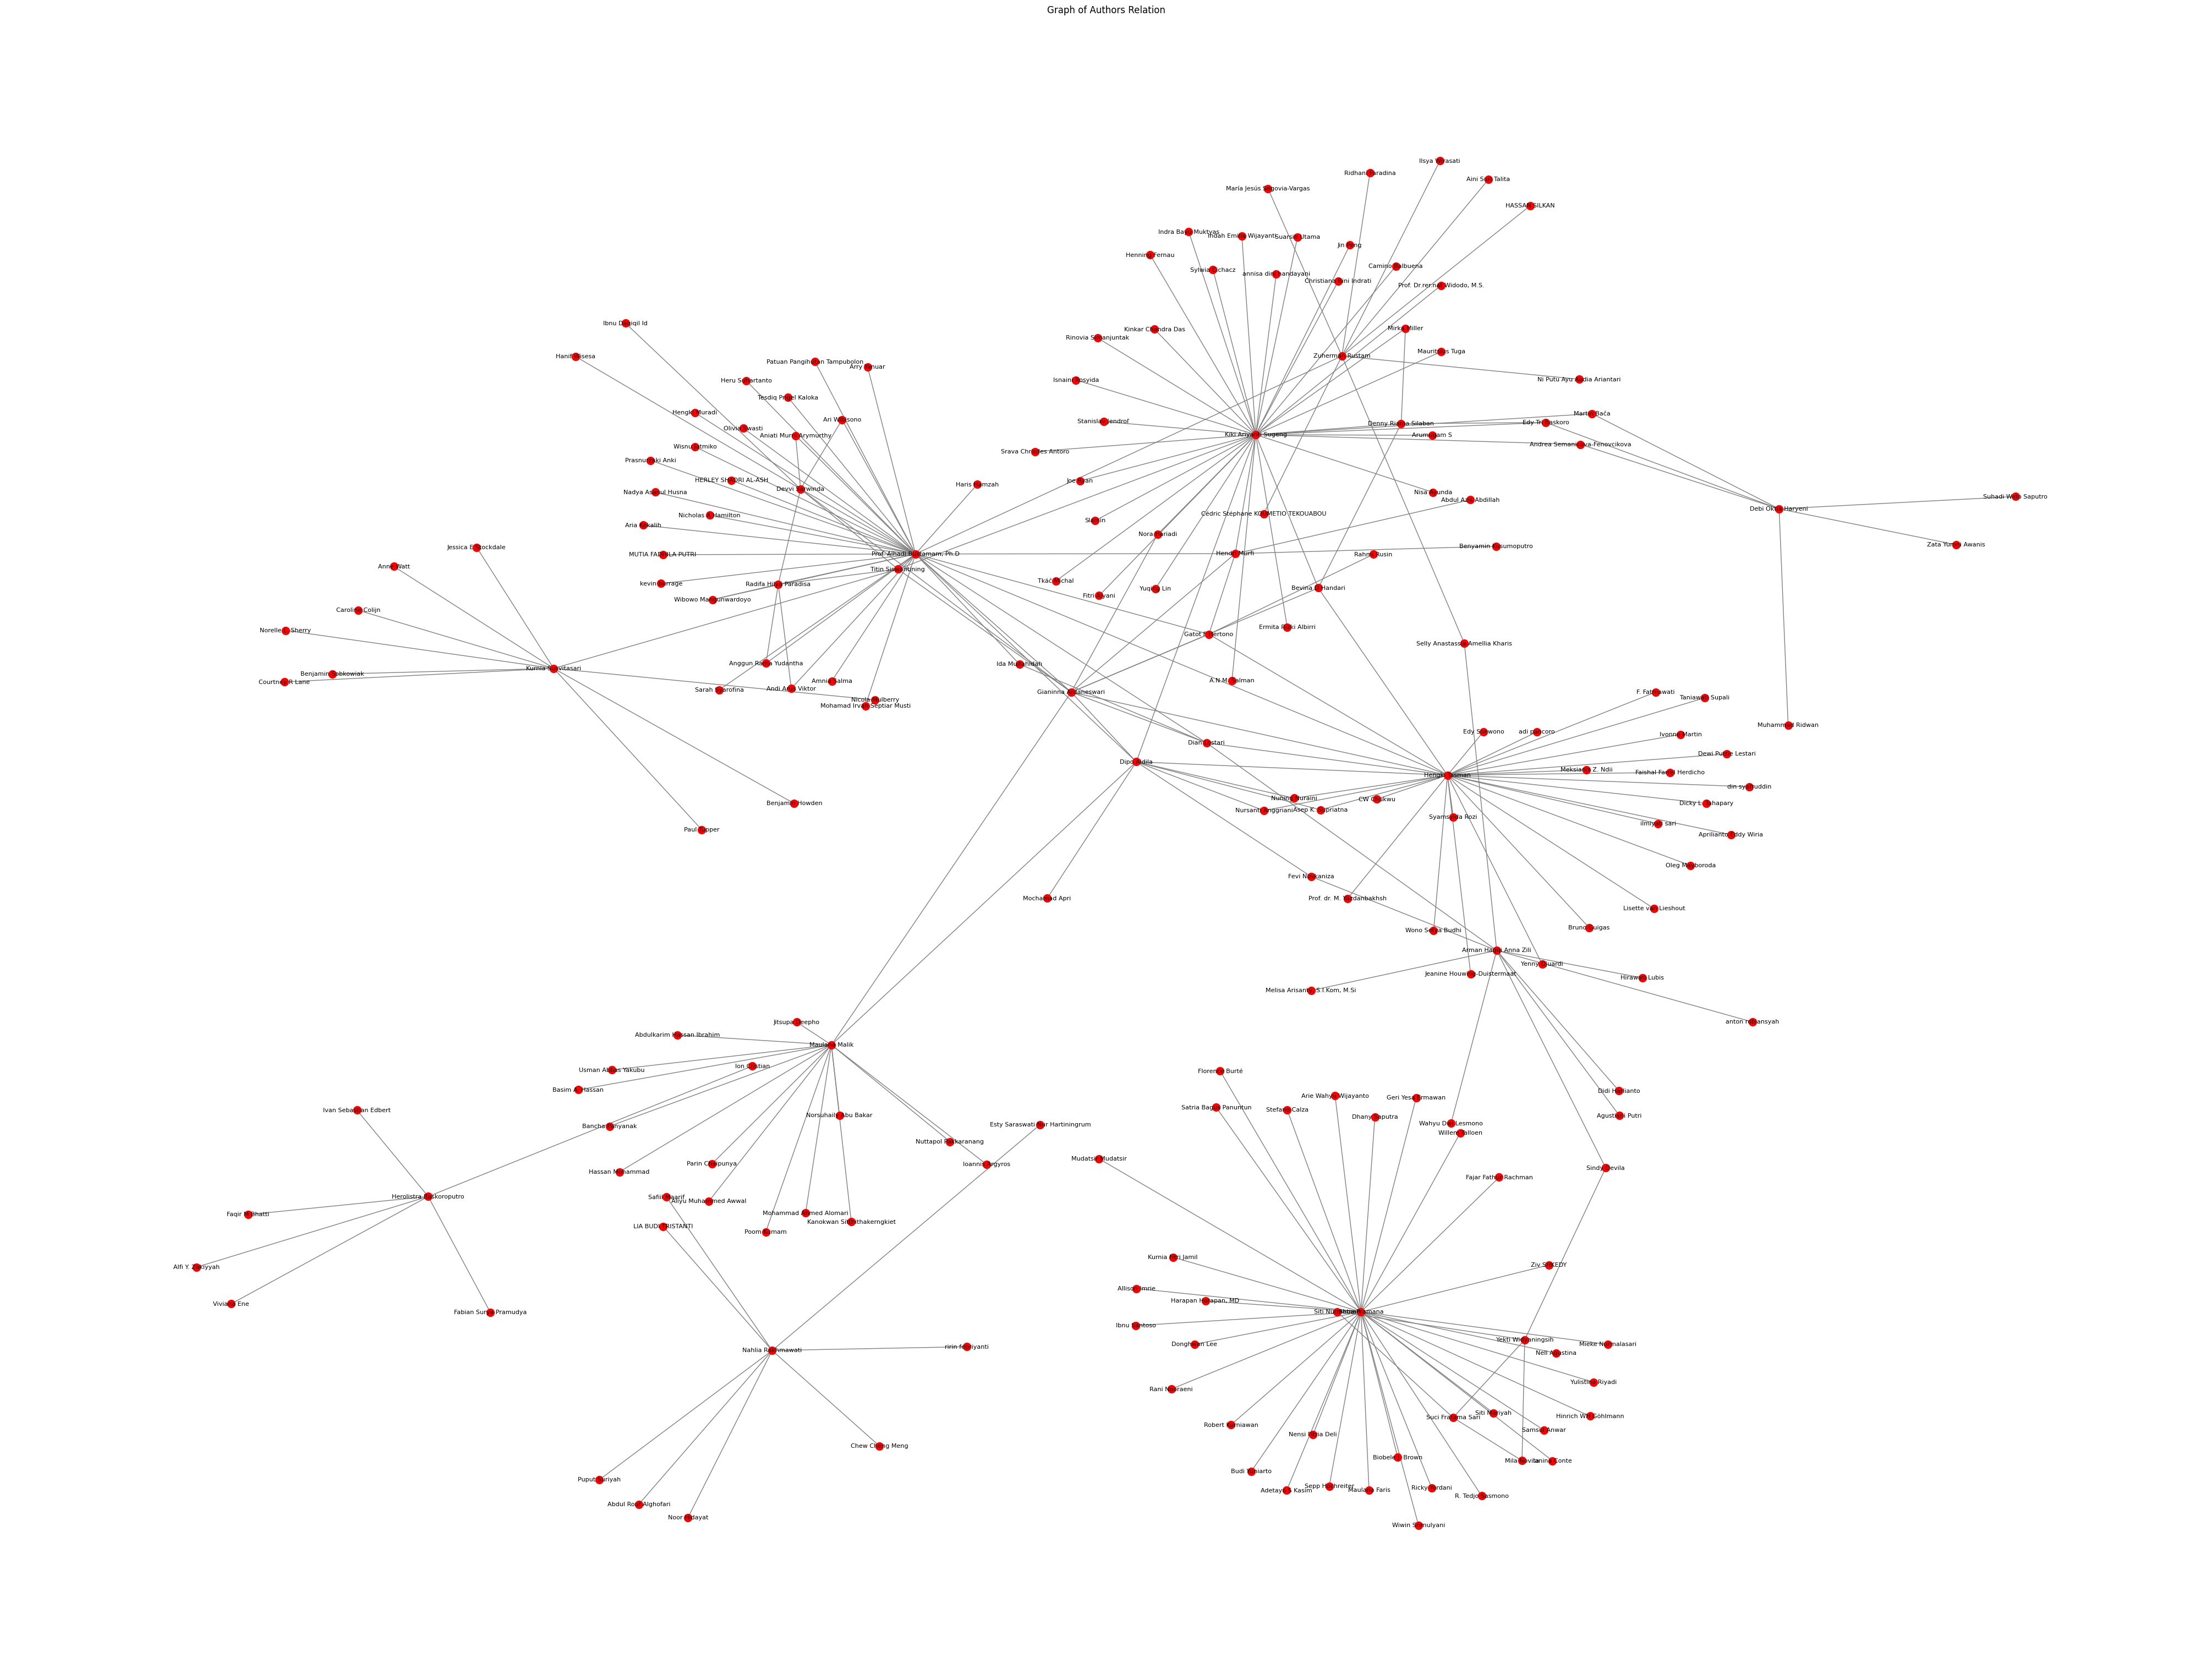

In [13]:
# draw the graph

posi = nx.spring_layout(G, k = 0.2, iterations = 50, seed = 42)

plt.figure(figsize=(40, 30))
nx.draw(
    G,
    pos = posi,
    with_labels=True,
    node_color='red',
    edge_color='gray',
    node_size=100,
    font_size=8
)
plt.title("Graph of Authors Relation")
plt.show()

In [14]:
adj_matek = nx.to_numpy_array(G, dtype=np.float32)

print("Numpy Adjacency Matrix:\n")
print_matrix(adj_matek)

Numpy Adjacency Matrix:

0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 

In [15]:
start = time.time()
MarkovMatrix = run_mcl(adj_matek, expansion = 2, inflation=2, iteration=100)
end = time.time()

print(f"Time to compute: {end - start} seconds")

0.35 0.13 0.07 0.26 0.26 0.11 0.20 0.17 0.26 0.02 0.08 0.26 0.26 0.26 0.17 0.17 0.26 0.16 0.02 0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.16 0.01 0.26 0.26 0.06 0.26 0.26 0.06 0.06 0.04 0.04 0.04 0.03 0.05 0.02 0.01 0.03 0.07 0.07 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.08 0.08 0.18 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.02 0.03 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.05 0.05 0.05 0.05 0.05 0.05 0.05
0.03 0.24 

In [16]:
print_matrix(MarkovMatrix)

1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 

In [17]:
clustersnya = mc.get_clusters(MarkovMatrix)

In [18]:
for i, cluster in enumerate(clustersnya):
    print(f"Cluster {i}: {cluster}")

Cluster 0: (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 119, 120, 121)
Cluster 1: (9, 18, 35, 36, 37, 39, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99)
Cluster 2: (27, 154, 191, 192, 193, 194, 195, 196, 197)
Cluster 3: (30, 43, 44)
Cluster 4: (38, 115, 153, 154, 155, 156, 157, 158, 159, 160)
Cluster 5: (40, 42, 122, 123, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152)
Cluster 6: (41, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113)
Cluster 7: (45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78)
Cluster 8: (114, 116, 117, 118)
Cluster 9: (124, 128, 161, 162, 163, 164)
Cluster 10: (165, 166, 167, 168, 169, 170, 171)
Cluster 11: (172, 173, 174, 175, 176, 177, 178, 179, 180, 181)
Cluster 12: (1

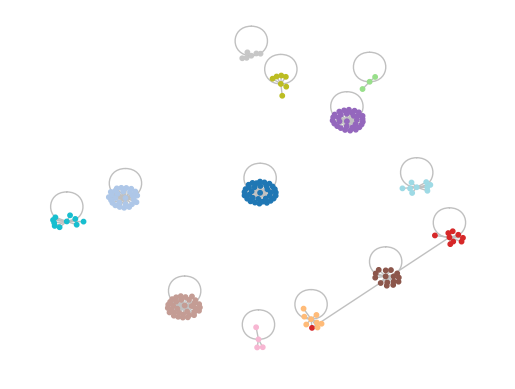

In [19]:
mc.draw_graph(MarkovMatrix, clustersnya, node_size=10, with_labels=False, edge_color="silver")

Gatau cara hilangin edge anehnya

Gambar disimpan sebagai mcl_graph.png


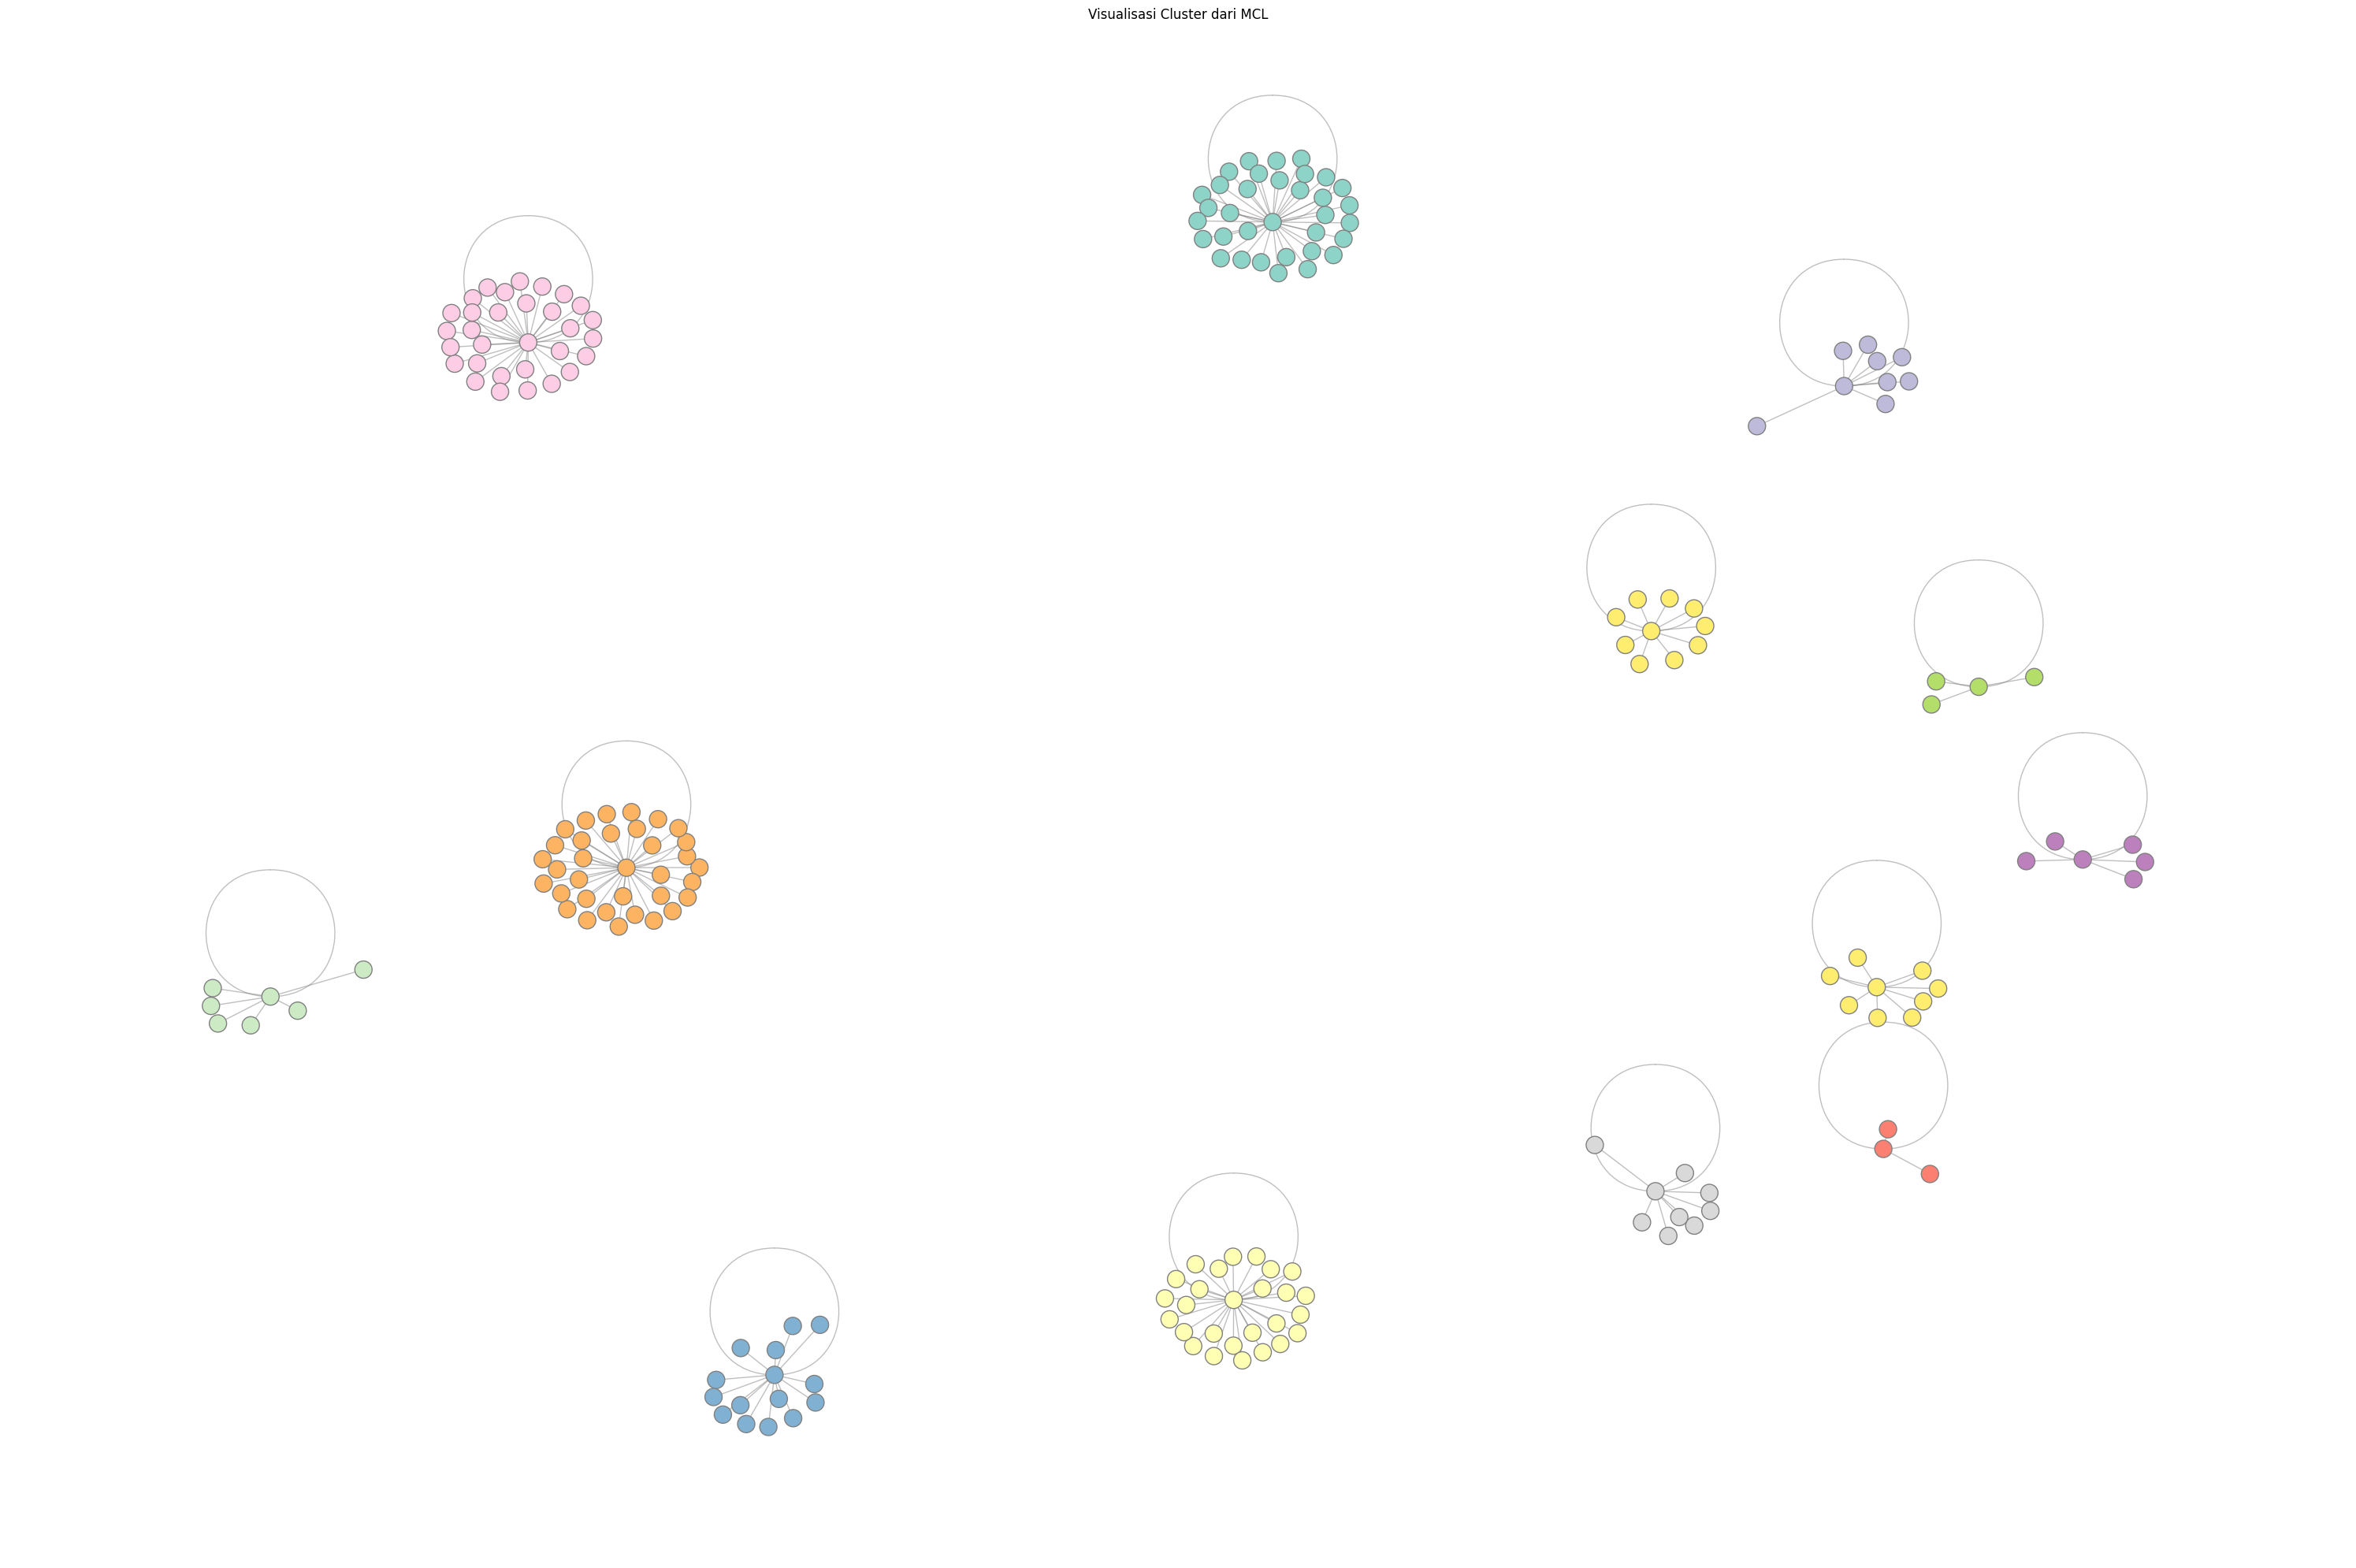

In [34]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# === 1. MCL Matrix Sample ===
matriks_mcl = MarkovMatrix.copy()

# === 2. Extract Clusters ===
def extract_clusters(mtx, threshold=0.01):
    binary = (mtx > threshold).astype(int)
    clusters = []
    visited = set()
    for i in range(binary.shape[0]):
        if i in visited:
            continue
        cluster = set(np.nonzero(binary[i])[0])
        if cluster:
            clusters.append(tuple(cluster))
            visited.update(cluster)
    return clusters

clusters = extract_clusters(matriks_mcl)

# === 3. Create Graph ===
adj_matrix = (matriks_mcl > 0.01).astype(int)
G = nx.from_numpy_array(adj_matrix)

# Assign cluster IDs
cluster_dict = {}
for cluster_id, cluster in enumerate(clusters):
    for node in cluster:
        cluster_dict[node] = cluster_id

# === 4. Draw and Save PNG ===
pos = nx.spring_layout(G, seed=42)
node_colors = [cluster_dict.get(node, -1) for node in G.nodes]

plt.figure(figsize=(30, 20))
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap=plt.cm.Set3,
    node_size=250,
    edgecolors='gray',
    label=True
)
# nx.draw_networkx_labels(G, pos)

plt.title("Visualisasi Cluster dari MCL")
plt.axis('off')
plt.tight_layout()

'''# ✅ Save to PNG
plt.savefig("mcl_graph.png", dpi=300)
plt.close()'''

print("Gambar disimpan sebagai mcl_graph.png")
